# Set up

In [118]:
# Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [ ]:
# Load data
dfStudents = pd.read_csv("Data/data.csv", sep=';')
dfStudents = dfStudents.sample(frac=1)
dfStudents.shape
dfStudents.head(3)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout


# Data Cleaning

In [8]:
# Remove rows with nulls if it's less than 5% of the data
if ((dfStudents.isna().any(axis=1).sum())/dfStudents.shape[0]) < .05:
    dfStudents.dropna(inplace=True)

# EDA

In [6]:
dfStudents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [4]:
dfStudents['Target'].value_counts()

Graduate    2209
Dropout     1421
Enrolled     794
Name: Target, dtype: int64

In [133]:
dfStudents['International'].value_counts()

0    4314
1     110
Name: International, dtype: int64

# Preprocess

In [120]:
# Encode target
aLabelEncoder = LabelEncoder()
dfStudents['encodedTarget'] = aLabelEncoder.fit_transform(dfStudents['Target'])
# Add 1 to avoid 0 bias
dfStudents['encodedTarget']  = dfStudents['encodedTarget'] + 1 

## Train test split

In [81]:
from sklearn.model_selection import train_test_split

XFeatures = dfStudents.drop(["Target", 'encodedTarget'], axis=1)
yTarget = dfStudents[['encodedTarget']]

XTrain, XTest, yTrain, yTest = train_test_split(
    XFeatures, yTarget, test_size=0.3, random_state=42, stratify=yTarget
)

## Correlation

c:\Users\RandomCat\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\RandomCat\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

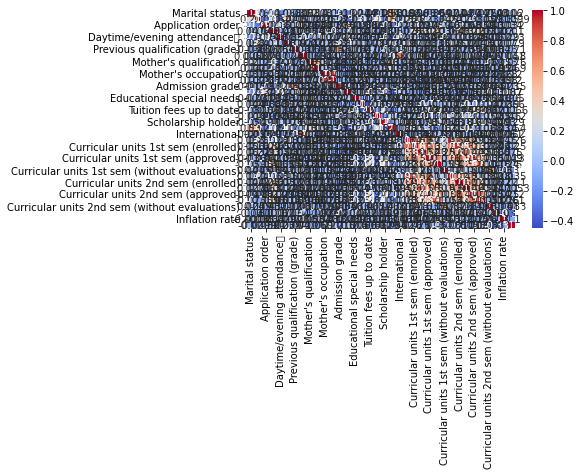

In [46]:
corrMatrix = XTrain.corr()
# plt.figure(figsize=(10, 8))
sns.heatmap(corrMatrix, annot=True, cmap="coolwarm")
# plt.savefig(
#     os.path.join(
#         "processedData",
#         f"featuresCorrelationMatrixBranch_{aBranch}.jpg",
#     )
# )

## Mutual information

In [82]:
def make_mi_scores(X_MI, y_MI):
    mi_scores = mutual_info_regression(X_MI, y_MI, discrete_features="auto")
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_MI.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


mIScores = make_mi_scores(XTrain, yTrain)

mIScores[::3]

c:\Users\RandomCat\anaconda3\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Curricular units 2nd sem (approved)       0.297006
Curricular units 1st sem (grade)          0.191267
Curricular units 2nd sem (evaluations)    0.070917
Age at enrollment                         0.062554
Curricular units 1st sem (enrolled)       0.044802
Previous qualification (grade)            0.037666
Father's occupation                       0.020562
Father's qualification                    0.007251
Curricular units 2nd sem (credited)       0.000164
Marital status                            0.000000
International                             0.000000
Nacionality                               0.000000
Name: MI Scores, dtype: float64

In [83]:
# Remove lower mi scores features
selectedFeatures = mIScores[mIScores > 0.01].index.tolist()
XTrain = XTrain[selectedFeatures].copy()
XTest = XTest[selectedFeatures].copy()

# Model

In [108]:
# Pipeline
categoricFeatures = XTrain.select_dtypes('object').columns.tolist()
numericFeatures = XTrain.select_dtypes('number').columns.tolist()

transform = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(), categoricFeatures),
        ("num_imputer", SimpleImputer(strategy="median"), numericFeatures),
        ("num_scaler", StandardScaler(), numericFeatures),
    ]
)
pipe = Pipeline(
    steps=[
        ("preprocessing", transform),
        ("model", RandomForestClassifier(n_estimators=50, random_state=42)),
    ]
)
pipe.fit(XTrain, yTrain)

c:\Users\RandomCat\anaconda3\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encoder', OrdinalEncoder(),
                                                  []),
                                                 ('num_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['Curricular units 2nd sem '
                                                   '(approved)',
                                                   'Curricular units 2nd sem '
                                                   '(grade)',
                                                   'Curricular units 1st sem '
                                                   '(approved)',
                                                   'Curricular units 1st sem '
                                                   '(grade)',
                                                   'Tuition fees up to date',
                                                   'Scholarship holder',
                                                   'Curricular units 2nd sem '
                                                   '...
                                                   'Curricular units 1st sem '
                                                   '(evaluations)',
                                                   'Age at enrollment',
                                                   'Curricular units 2nd sem '
                                                   '(enrolled)',
                                                   'Debtor',
                                                   'Curricular units 1st sem '
                                                   '(enrolled)',
                                                   'Application mode',
                                                   'Previous qualification',
                                                   'Previous qualification '
                                                   '(grade)',
                                                   'Gender', 'Admission grade',
                                                   "Father's occupation",
                                                   "Mother's "
                                                   'qualification'])])),
                ('model',
                 RandomForestClassifier(n_estimators=50, random_state=42))])

## Model Quality

In [109]:
from sklearn.metrics import accuracy_score, f1_score

predictions = pipe.predict(XTest)
accuracy = accuracy_score(yTest, predictions)
f1 = f1_score(yTest, predictions, average="macro")

print("Accuracy:", str(round(accuracy, 2) * 100) + "%", "F1:", round(f1, 2))

Accuracy: 78.0% F1: 0.71


In [132]:
# Feature importance
pd.DataFrame(
    {"feature": XFeatures.columns, "importance": pipe.named_steps['model'].feature_importances_[:len(XFeatures.columns)] }
).sort_values(by="importance", ascending=False).reset_index(drop=True)

,feature,importance
0,International,0.092400
1,Marital status,0.091761
2,Curricular units 1st sem (credited),0.058330
3,Curricular units 1st sem (enrolled),0.057468
4,Application mode,0.047894
5,Curricular units 1st sem (evaluations),0.038740
6,Course,0.037256
7,Application order,0.035600
8,Gender,0.032197
9,GDP,0.025845


In [70]:
# Save model quality metrics
with open("Results/metrics.txt", "w") as outputFile:
    outputFile.write(f"\nAccuracy = {round(accuracy, 2)}, F1 Score = {round(f1, 2)}.")

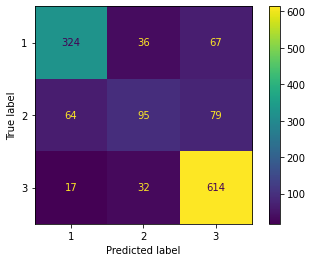

In [95]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

confusionMatrix = confusion_matrix(yTest, predictions, labels=pipe.classes_)
confusionFig = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=pipe.classes_)
confusionFig.plot()
# plt.savefig("Results/modelResults.png", dpi=120)

In [119]:
print(classification_report(yTest, predictions))

              precision    recall  f1-score   support

           1       0.80      0.76      0.78       427
           2       0.58      0.40      0.47       238
           3       0.81      0.93      0.86       663

    accuracy                           0.78      1328
   macro avg       0.73      0.69      0.71      1328
weighted avg       0.77      0.78      0.77      1328



In [75]:
import skops.io as sio

sio.dump(pipe, "Model/studentsPipeline.skops")

In [129]:
# Output data
dfOutput = dfStudents.copy()
dfOutput['predictedStudentStateEncoded'] =  pipe.predict(XFeatures)
# Inverse transform the predicted encoded variables
dfOutput['predictedStudentState'] = aLabelEncoder.inverse_transform( dfOutput['predictedStudentStateEncoded'] - 1)
dfOutput['predictedStudentDropoutProbatility'] =  pipe.predict_proba(XFeatures)[:, 0]
dfOutput['predictedStudentEnrolledProbatility'] =  pipe.predict_proba(XFeatures)[:, 1]
dfOutput['predictedStudentGraduateProbatility'] =  pipe.predict_proba(XFeatures)[:, 2]

In [ ]:
dfOutput[
    [
        "Target",
        "predictedStudentState",
        "predictedStudentDropoutProbatility",
        "predictedStudentEnrolledProbatility",
        "predictedStudentGraduateProbatility",
    ]
].rename(columns={"Target": "studentState"})

,studentState,predictedStudentState,predictedStudentDropoutProbatility,predictedStudentEnrolledProbatility,predictedStudentGraduateProbatility
0,Dropout,Dropout,0.86,0.04,0.10
1,Graduate,Graduate,0.06,0.04,0.90
2,Dropout,Dropout,0.98,0.02,0.00
3,Graduate,Graduate,0.06,0.06,0.88
4,Graduate,Graduate,0.00,0.04,0.96
...,...,...,...,...,...
4419,Graduate,Graduate,0.08,0.08,0.84
4420,Dropout,Dropout,0.84,0.08,0.08
4421,Dropout,Dropout,0.72,0.12,0.16
4422,Graduate,Graduate,0.02,0.00,0.98


In [ ]:
# import black